In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold, ParameterGrid

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of compounds", df.shape[0])
    return df

In [3]:
def drop_low_frequency_elements(df, limit):
    elem_counts = pd.Series(np.hstack(np.array(df.species))).value_counts()
    low_freq = elem_counts[elem_counts < limit].index.values
    low_freq_mask = df.species.apply(lambda s: len(np.setdiff1d(s, low_freq)) < len(s))
    df = df[~low_freq_mask]
    print("Number of compounds", df.shape[0])
    return df

In [4]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [5]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            nn.SELU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU())
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.SELU(),
                                        nn.Linear(32, 8),
                                        nn.SELU(),
                                        nn.Linear(8, 1))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.regressor(x)
        return x

In [6]:
data_name = "all_3_species_oxides"
fig_folder = "plots/"

In [7]:
df = pd.read_pickle(f"data/{data_name}.pkl")
df = drop_duplicates(df)
df = drop_low_frequency_elements(df, 50)
df

Number of compounds 5456
Number of compounds 5237


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b281fdee92d2d2b2,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOOs_pv/...,Ag1O3Os1,"[1, 3, 1]","[Ag, O, Os]",5,221,cP5,"[3.9184369, 3.9184369, 3.9184369, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.95922, 1.95922], [1....",-5.34058,0.427456
2,aflow:0783c5b47a9319f1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOP/T000...,Ag1O3P1,"[1, 3, 1]","[Ag, O, P]",5,221,cP5,"[3.57933, 3.57933, 3.57933, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [-0.0, 1.78966, 1.78966], [1...",-4.90593,-0.316921
4,aflow:701ef4b4f46ea7cd,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPb_d/T...,Ag1O3Pb1,"[1, 3, 1]","[Ag, O, Pb]",5,221,cP5,"[4.2942064, 4.2942064, 4.2942064, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 2.1471, 2.1471], [2.14...",-3.97006,0.295059
6,aflow:a7a77ee138e41496,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPd_pv/...,Ag1O3Pd1,"[1, 3, 1]","[Ag, O, Pd]",5,221,cP5,"[3.9991958, 3.9991958, 3.9991958, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.9996, 1.9996], [1.99...",-3.40735,1.19322
8,aflow:5fee8d04571dae6f,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPt/T00...,Ag1O3Pt1,"[1, 3, 1]","[Ag, O, Pt]",5,221,cP5,"[3.9809833, 3.9809833, 3.9809833, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.99049, 1.99049], [1....",-3.71702,1.01812
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,aflow:c118e80e9244085e,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/HEX/O8Ta2...,O8Ta2U1,"[8, 2, 1]","[O, Ta, U]",11,162,hP11,"[6.30035, 6.30035, 3.951854, 89.99958, 89.9995...","[[0.33333209, 0.66666791, 0.5], [0.66666791, 0...","[[3.15012, 1.81878, 1.97595], [3.15012, -1.818...",-8.62130,None
11882,aflow:8eb178cdfcb71dff,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/HEX/O4Tl2...,O8Tl4W2,"[8, 4, 2]","[O, Tl, W]",14,164,hP14,"[6.486511, 6.486511, 8.314123, 90.00137, 89.99...","[[0.66668892, 0.33331108, 0.47188912], [0.3333...","[[3.2432, -1.87281, 3.92337], [3.2432, 1.87269...",-6.64453,None
11884,aflow:dd0ff61000b8e748,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V1Y...,O8V2Y2,"[8, 2, 2]","[O, V, Y]",12,141,tI24,"[6.019827, 6.019827, 6.019827, 106.199, 106.19...","[[0.86631316, 0.80059798, 0.065715186], [0.234...","[[0.0, 0.47505, 5.09108], [3.61447, -0.47505, ...",-8.44561,None
11898,aflow:36a24bb71d323a35,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V2Z...,O8V4Zn2,"[8, 4, 2]","[O, V, Zn]",14,141,tI28,"[5.976299, 5.976299, 5.976299, 120.0156, 120.0...","[[0.25815325, 0.24220713, 0.98405389], [0.2581...","[[2.89217, 2.98745, -2.04451], [3.08272, 0.0, ...",-7.07798,None


In [8]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(72,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Er', 'Eu', 'F', 'Fe',
        'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'I', 'In', 'Ir', 'K', 'La',
        'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'O', 'Os',
        'P', 'Pb', 'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'S', 'Sb',
        'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tc', 'Te', 'Ti', 'Tl', 'U',
        'V', 'W', 'Xe', 'Y', 'Zn', 'Zr'], dtype='<U2'))

In [9]:
net = VoxelNet(nchannel)
count_parameters(net)

78049

## Parameters

In [10]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
weight_decay = 0.01

device = get_default_device()

##  Cartesian

(4189, 13) (524, 13) (524, 13)
Initialised MolLoader with 4189 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=72, mode=cartesian, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 524 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=72, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
Initialised MolLoader with 524 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=72, mode=cartesian, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=cartesian
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Epoch 0: train loss 5.6960 val loss 2.5750 test loss 2.2053 -> best val loss!
Epoch 1: train loss 2.1772 val loss 2.1610 test loss 1.8025 -> best val loss!
Epoch 2: train loss 1.0808 val loss 0.5772 test loss 0.5160 -> best val loss!
Epoch 3: train loss 0.5274 val loss 0.5361 te

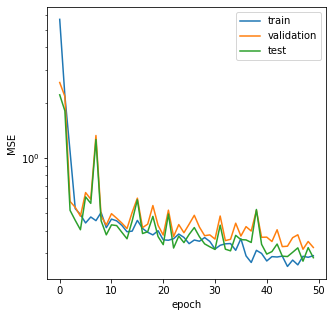

In [11]:
seed_everything()
train_df, holdout_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(holdout_df, test_size=0.5)
print(train_df.shape, val_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     device=device, mode='cartesian')

ml_val = MolLoader(val_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='cartesian')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='cartesian')

best_net = fit(epochs, net, ml_train, ml_val, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weight_decay, val_epochs=5)

### Train Plots

MSE 0.24858224
MAE 0.37220126


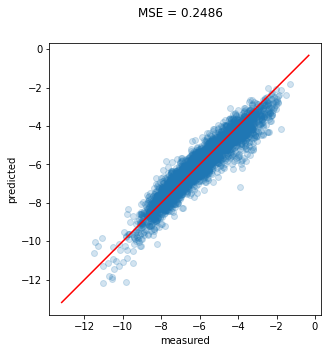

In [12]:
# 0.2486
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_cartesian_train_orig.pdf")

Mean Variance:  0.008196224
MSE 0.2168324
MAE 0.34123257


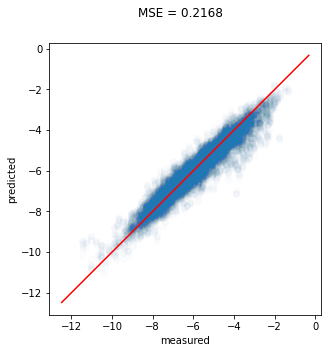

In [13]:
# 0.2168
# transformations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats, alpha=0.01)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_cartesian_train.pdf")

### Test Plots

MSE 0.2985506
MAE 0.39433208


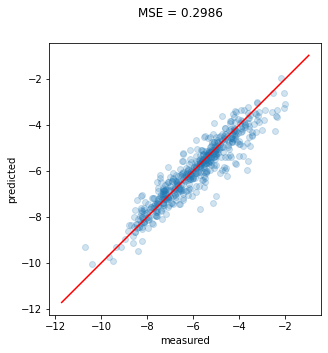

In [14]:
# 0.2986
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_cartesian_test_orig.pdf")

Mean Variance:  0.00800409
MSE 0.27580863
MAE 0.3751013


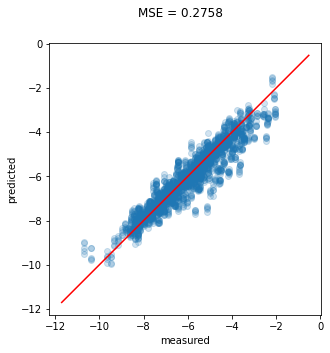

In [15]:
# 0.2758
# transformations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_cartesian_test.pdf")

In [16]:
torch.save(best_net.cpu().state_dict(), "nets/"+ data_name + "_cartesian.pth")

## Spherical

(4189, 13) (524, 13) (524, 13)
Initialised MolLoader with 4189 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=72, mode=spherical, device=cuda
    shuffle=True, rotate=True, reflect=True, mode=spherical
Initialised MolLoader with 524 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=72, mode=spherical, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=spherical
Initialised MolLoader with 524 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=72, mode=spherical, device=cuda
    shuffle=False, rotate=True, reflect=True, mode=spherical
opt: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
), number of epochs: 50, validation epochs: 5
Epoch 0: train loss 5.5974 val loss 2.2971 test loss 1.9820 -> best val loss!
Epoch 1: train loss 1.4683 val loss 1.0594 test loss 1.1188 -> best val loss!
Epoch 2: train loss 0.7192 val loss 0.5748 test loss 0.5610 -> best val loss!
Epoch 3: train loss 0.5604 val loss 0.5486 te

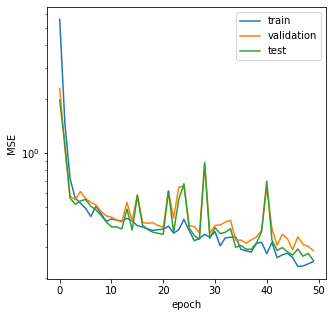

In [17]:
seed_everything()
train_df, holdout_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(holdout_df, test_size=0.5)
print(train_df.shape, val_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                     L=L, N=N, batch_size=64, nchannel=nchannel,
                     shuffle=True, rotate_randomly=True, reflect_randomly=True,
                     device=device, mode='spherical')

ml_val = MolLoader(val_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='spherical')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                    L=L, N=N, batch_size=128, nchannel=nchannel,
                    shuffle=False, rotate_randomly=True, reflect_randomly=True,
                    device=device, mode='spherical')

best_net = fit(epochs, net, ml_train, ml_val, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weight_decay, val_epochs=5)

### Train Plots

MSE 0.21649383
MAE 0.33361918


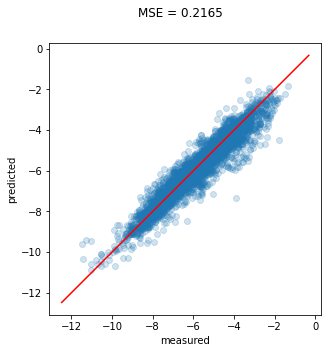

In [18]:
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_spherical_train_orig.pdf")

Mean Variance:  0.0013668209
MSE 0.1999998
MAE 0.32155082


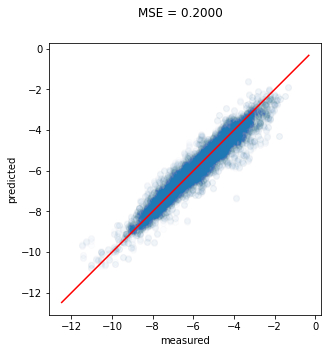

In [19]:
# transformations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats, alpha=0.01)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_spherical_train.pdf")

### Test Plots

MSE 0.26549724
MAE 0.3705287


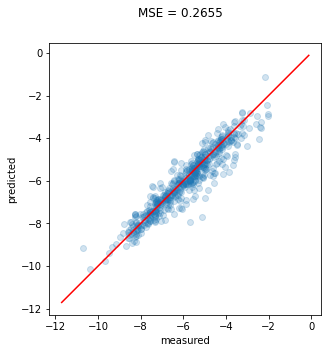

In [20]:
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False, reflect_randomly=False)
ys, y_hats = predict(best_net, ml_pred)
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_spherical_test_orig.pdf")

Mean Variance:  0.0013265632
MSE 0.2504762
MAE 0.36063


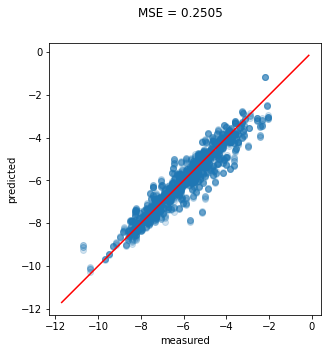

In [21]:
# transformations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True, reflect_randomly=True)
ys, y_hats = predict_epochs(best_net, ml_pred, epochs=5)
print("Mean Variance: ", np.mean(np.var(y_hats.reshape(5,-1), axis=0)))
plot_predictions(ys, y_hats)
print("MSE", np.mean((ys - y_hats)**2))
print("MAE", np.mean(np.abs(ys - y_hats)))
plt.savefig(fig_folder + data_name + "_spherical_test.pdf")

In [22]:
torch.save(best_net.cpu().state_dict(), "nets/"+ data_name + "_spherical.pth")